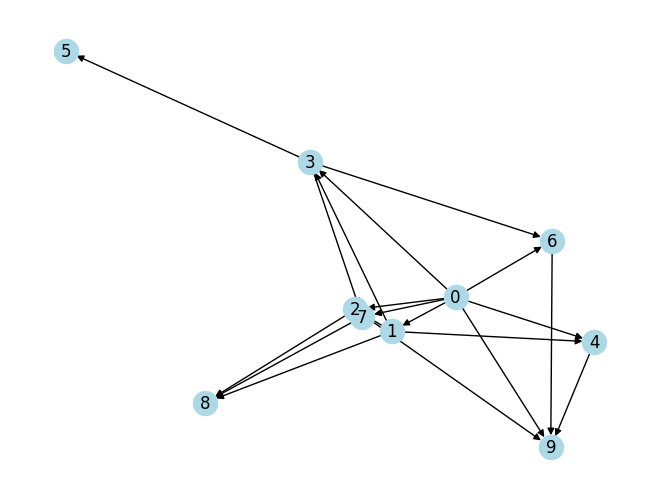

In [19]:
import networkx as nx

G = nx.dense_gnm_random_graph(10, 20)

DG = nx.DiGraph()

for edge in nx.edges(G):
    DG.add_edge(edge[0], edge[1])
nx.draw(DG, node_color='lightblue', 
        with_labels=True, 
        node_size=300)


In [4]:

import networkx as nx
import random
import time
import statistics
from graph import Graph
import matplotlib.pyplot as plt
import gc
import copy

def convert_to_graph(nx_graph):
    net = {}
    for u in nx_graph.nodes():
        if u not in net:
            net[u] = {}

    for u, v, data in nx_graph.edges(data=True):
        capacity = data['capacity']
        if u not in net:
            net[u] = {}
        net[u][v] = {'capacity': capacity}

    source = min(nx_graph.nodes)
    sink = max(nx_graph.nodes)

    return Graph(net, source, sink)

def generate_high_capacity_graph(n, U):
    G = nx.complete_graph(n, create_using=nx.DiGraph())
    # DG = nx.DiGraph()
    for edge in nx.edges(G):
        G[edge[0]][edge[1]]['capacity'] = random.randint(1, U)
        G[edge[1]][edge[0]]['capacity'] = random.randint(1, U)
    
    return G 

def generate_gnm_graph(n, m, U):
    G = nx.dense_gnm_random_graph(n, m, U) # работает быстрее, чем обычный gnm (см. документацию)

    DG = nx.DiGraph() # создаем ориентированный граф

    for edge in nx.edges(G): 
        DG.add_edge(edge[0], edge[1]) # добавляем в ориентированный граф ребра из неорграфа G
        DG[edge[0]][edge[1]]['capacity'] = random.randint(1, U) 

    return DG

def run_experiment(n, m, U, num_tests=50, method="gnm"):
    times_edmonds_karp = []
    times_push_relabel = []

    for _ in range(num_tests):
        if method == "gnm":
            G = generate_gnm_graph(n, m, U)
        if method == "complex_high_capacity":
            G = generate_high_capacity_graph(n, U)
        else:
            G = generate_gnm_graph(n, m, U)




        g_ek, diGraph = convert_to_graph(G), G
        g_prf = copy.deepcopy(g_ek)
        # src, snk = g_ek.source, g_ek.sink
        # Edmonds-Karp
        start_time = time.time()
        max_flow_ek = g_ek.edmonds_karp()
        end_time = time.time()
        times_edmonds_karp.append(end_time - start_time)
        # print(f'ek {max_flow_ek} == {nx.maximum_flow_value(diGraph, src, snk)}')
        gc.collect()

        # Push-Relabel
        start_time = time.time()
        max_flow_pr = g_prf.FIFOPushRelabel()
        end_time = time.time()
        times_push_relabel.append(end_time - start_time)
        # print(f'prf {max_flow_pr} == {nx.maximum_flow_value(diGraph, src, snk)}')
        gc.collect()

    

    avg_time_ek = statistics.mean(times_edmonds_karp)
    worst_time_ek = max(times_edmonds_karp)
    avg_time_pr = statistics.mean(times_push_relabel)
    worst_time_pr = max(times_push_relabel)

    return (avg_time_ek, worst_time_ek, avg_time_pr, worst_time_pr)


# n = 10
# m = 15
# U = 20
# num_tests = 50

# run_experiment(n, m, U, num_tests)

n = 100, m = 330, U = 10, ek ср. время: 0.0003706169128417969, pr ср. время: 0.006930489540100098
n = 100, m = 660, U = 10, ek ср. время: 0.001560969352722168, pr ср. время: 0.008647613525390625
n = 100, m = 990, U = 10, ek ср. время: 0.0026411867141723634, pr ср. время: 0.006242022514343261
n = 100, m = 1320, U = 10, ek ср. время: 0.004538493156433105, pr ср. время: 0.02465890407562256
n = 100, m = 1650, U = 10, ek ср. время: 0.005536942481994629, pr ср. время: 0.0188248348236084
n = 100, m = 1980, U = 10, ek ср. время: 0.007707481384277344, pr ср. время: 0.01941725254058838
n = 100, m = 2310, U = 10, ek ср. время: 0.010241856575012207, pr ср. время: 0.0366248607635498
n = 100, m = 2640, U = 10, ek ср. время: 0.013358602523803711, pr ср. время: 0.04435888767242432
n = 100, m = 2970, U = 10, ek ср. время: 0.015012760162353516, pr ср. время: 0.043750858306884764
n = 100, m = 3300, U = 10, ek ср. время: 0.017281923294067383, pr ср. время: 0.045628929138183595
n = 100, m = 3630, U = 10, e

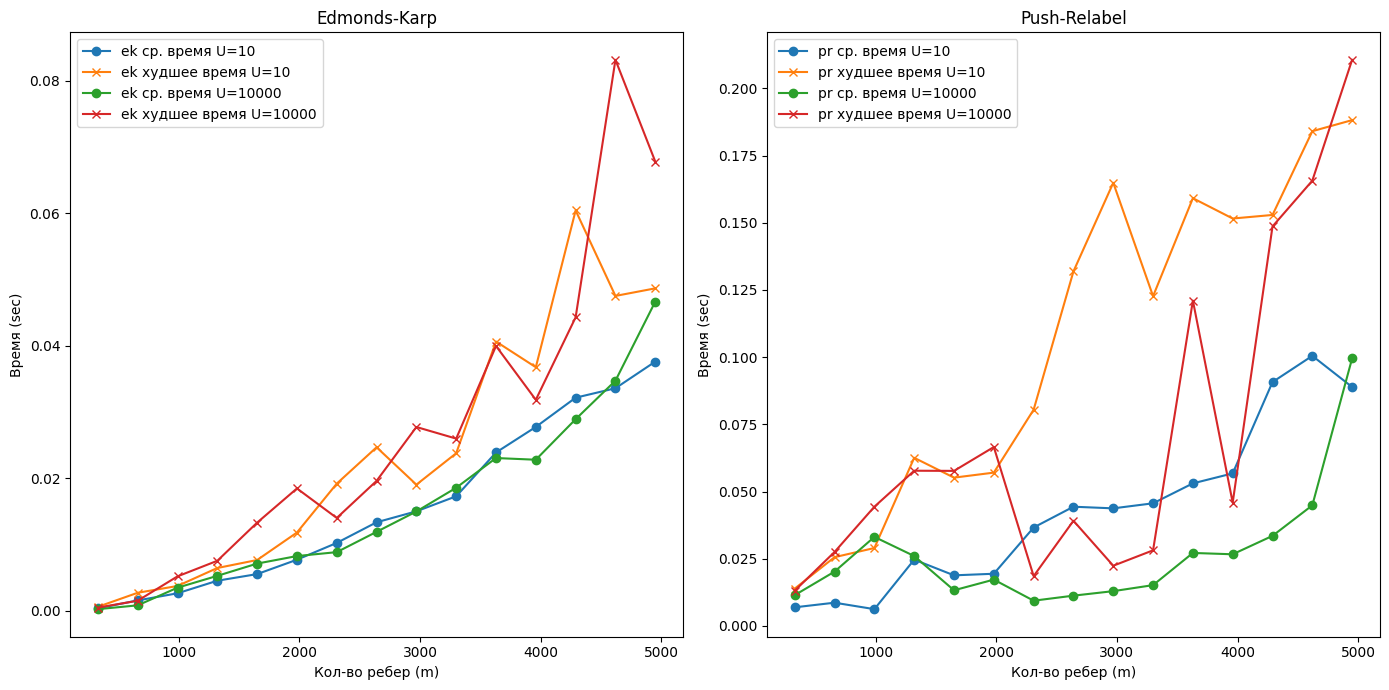

In [5]:
import pandas as pd

n = 100
U_values = [10, 10000]
# m_values = [258, 344, 501, 712, 1123]
m_values = list(range(330, 4951, 330))
# m_values = [int(n * (n - 1) / i) for i in range(100, 1, -18)]

num_tests = 50 

results = []

for U in U_values:
    for m in m_values:
        avg_time_ek, worst_time_ek, avg_time_pr, worst_time_pr = run_experiment(n, m, U, num_tests)
        results.append({
            'n': n,
            'm': m,
            'U': U,
            'ek avg time': avg_time_ek,
            'ek worst time': worst_time_ek,
            'pr avg time': avg_time_pr,
            'pr worst time': worst_time_pr
        })
        print(f'n = {n}, m = {m}, U = {U}, ek ср. время: {avg_time_ek}, pr ср. время: {avg_time_pr}')

df = pd.DataFrame(results)
# print(df_results)

plt.figure(figsize=(14, 7))

for U in df['U'].unique():
    df_U = df[df['U'] == U]
    
    plt.subplot(1, 2, 1)
    plt.plot(df_U['m'], df_U['ek avg time'], label=f'ek ср. время U={U}', marker='o')
    plt.plot(df_U['m'], df_U['ek worst time'], label=f'ek худшее время U={U}', marker='x')

    plt.subplot(1, 2, 2)
    plt.plot(df_U['m'], df_U['pr avg time'], label=f'pr ср. время U={U}', marker='o')
    plt.plot(df_U['m'], df_U['pr worst time'], label=f'pr худшее время U={U}', marker='x')

plt.subplot(1, 2, 1)
plt.xlabel('Кол-во ребер (m)')
plt.ylabel('Время (sec)')
plt.title('Edmonds-Karp')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Кол-во ребер (m)')
plt.ylabel('Время (sec)')
plt.title('Push-Relabel')
plt.legend()

plt.tight_layout()
plt.show()

n = 200, m = 1990, U = 10, ek ср. время: 0.0036476945877075197, pr ср. время: 0.01564765453338623
n = 200, m = 3980, U = 10, ek ср. время: 0.012632060050964355, pr ср. время: 0.10261140346527099
n = 200, m = 5970, U = 10, ek ср. время: 0.03033997058868408, pr ср. время: 0.22426918029785156
n = 200, m = 7960, U = 10, ek ср. время: 0.05291884422302246, pr ср. время: 0.16387179374694824
n = 200, m = 9950, U = 10, ek ср. время: 0.08613468647003174, pr ср. время: 0.2348126459121704
n = 200, m = 11940, U = 10, ek ср. время: 0.11057301044464111, pr ср. время: 0.20673206806182862
n = 200, m = 13930, U = 10, ek ср. время: 0.13483974933624268, pr ср. время: 0.18277935981750487
n = 200, m = 15920, U = 10, ek ср. время: 0.20273529052734374, pr ср. время: 0.81747642993927
n = 200, m = 17910, U = 10, ek ср. время: 0.24790889263153076, pr ср. время: 0.8341931390762329
n = 200, m = 19900, U = 10, ek ср. время: 0.289033317565918, pr ср. время: 0.9140851354598999
n = 200, m = 1990, U = 10000, ek ср. вре

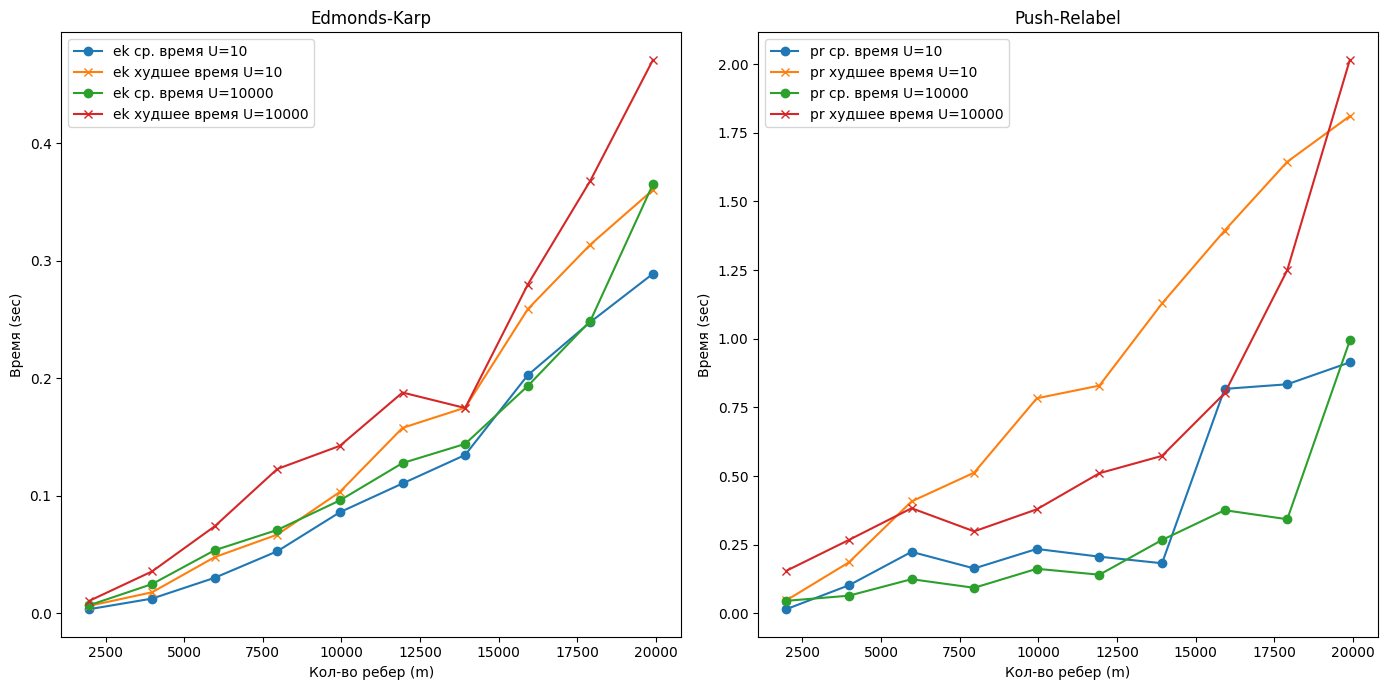

In [3]:
import pandas as pd

n = 200
U_values = [10, 10000]
# m_values = [258, 344, 501, 712, 1123]
m_values = list(range(1990, 19901, 1990))
# m_values = [int(n * (n - 1) / i) for i in range(100, 1, -18)]

num_tests = 50 

results = []

for U in U_values:
    for m in m_values:
        avg_time_ek, worst_time_ek, avg_time_pr, worst_time_pr = run_experiment(n, m, U, num_tests)
        results.append({
            'n': n,
            'm': m,
            'U': U,
            'ek avg time': avg_time_ek,
            'ek worst time': worst_time_ek,
            'pr avg time': avg_time_pr,
            'pr worst time': worst_time_pr
        })
        print(f'n = {n}, m = {m}, U = {U}, ek ср. время: {avg_time_ek}, pr ср. время: {avg_time_pr}')

df = pd.DataFrame(results)
# print(df_results)

plt.figure(figsize=(14, 7))

for U in df['U'].unique():
    df_U = df[df['U'] == U]
    
    plt.subplot(1, 2, 1)
    plt.plot(df_U['m'], df_U['ek avg time'], label=f'ek ср. время U={U}', marker='o')
    plt.plot(df_U['m'], df_U['ek worst time'], label=f'ek худшее время U={U}', marker='x')

    plt.subplot(1, 2, 2)
    plt.plot(df_U['m'], df_U['pr avg time'], label=f'pr ср. время U={U}', marker='o')
    plt.plot(df_U['m'], df_U['pr worst time'], label=f'pr худшее время U={U}', marker='x')

plt.subplot(1, 2, 1)
plt.xlabel('Кол-во ребер (m)')
plt.ylabel('Время (sec)')
plt.title('Edmonds-Karp')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Кол-во ребер (m)')
plt.ylabel('Время (sec)')
plt.title('Push-Relabel')
plt.legend()

plt.tight_layout()
plt.show()

n = 100, m = 4950.0, U = 1000000, ek ср. время: 0.11733880996704102, pr ср. время: 0.10929770469665527
n = 110, m = 5995.0, U = 1000000, ek ср. время: 0.163521990776062, pr ср. время: 0.17531725406646728
n = 120, m = 7140.0, U = 1000000, ek ср. время: 0.19358567237854005, pr ср. время: 0.21483998298645018
n = 130, m = 8385.0, U = 1000000, ek ср. время: 0.24411026477813721, pr ср. время: 0.27366727352142334
n = 140, m = 9730.0, U = 1000000, ek ср. время: 0.3132109069824219, pr ср. время: 0.36706048011779785
n = 150, m = 11175.0, U = 1000000, ek ср. время: 0.388305344581604, pr ср. время: 0.42171803951263426
n = 160, m = 12720.0, U = 1000000, ek ср. время: 0.5151164865493775, pr ср. время: 0.5576404237747192
n = 170, m = 14365.0, U = 1000000, ek ср. время: 0.591103105545044, pr ср. время: 0.7076374244689941
n = 180, m = 16110.0, U = 1000000, ek ср. время: 0.7273427963256835, pr ср. время: 0.6321521949768066


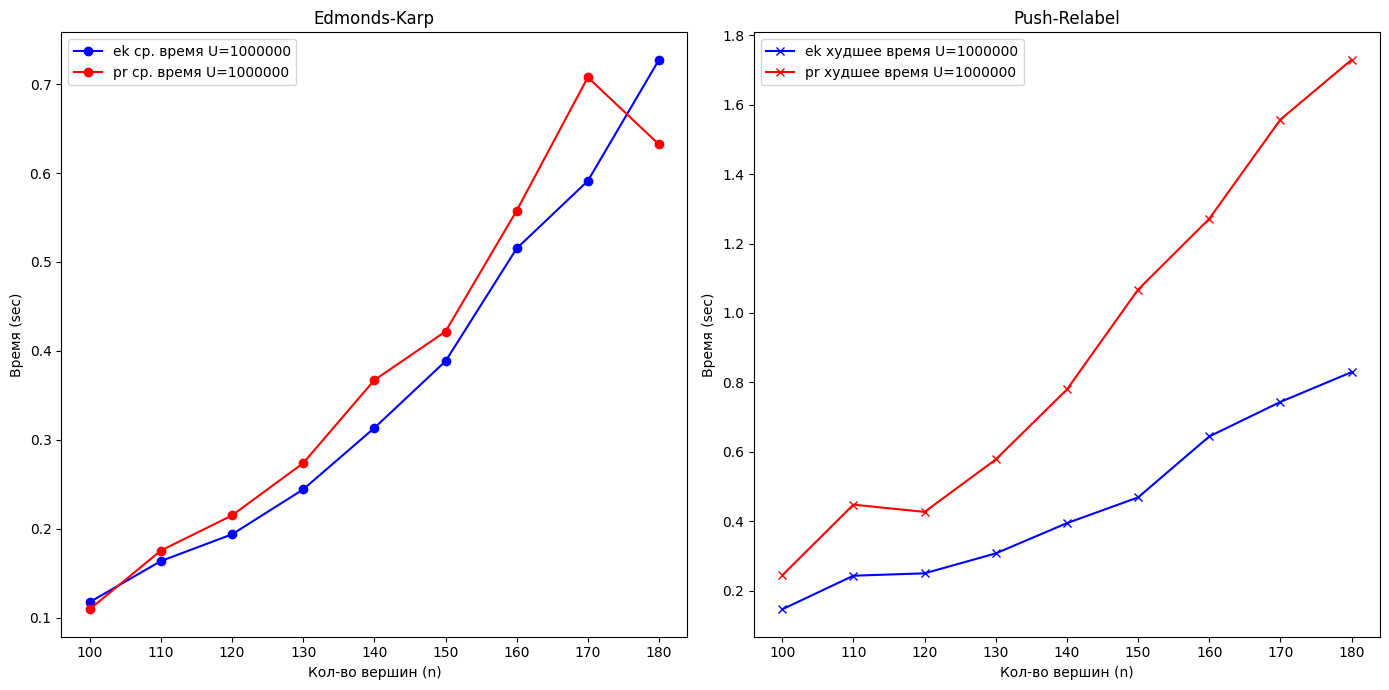

In [14]:
###### тест на полных графах ######
import pandas as pd
n_values = list(range(100, 181, 10))
U_value = 1000000


num_tests = 50 

results = []

for n in n_values:
    avg_time_ek, worst_time_ek, avg_time_pr, worst_time_pr = run_experiment(n, 0, U_value, num_tests, "complex_high_capacity")
    results.append({
        'n': n,
        'U': U_value,
        'ek avg time': avg_time_ek,
        'ek worst time': worst_time_ek,
        'pr avg time': avg_time_pr,
        'pr worst time': worst_time_pr
    })
    print(f'n = {n}, m = {n *(n-1)/2}, U = {U_value}, ek ср. время: {avg_time_ek}, pr ср. время: {avg_time_pr}')

df = pd.DataFrame(results)
# print(df_results)

plt.figure(figsize=(14, 7))

for U in df['U'].unique():
    df_U = df[df['U'] == U]
    
    plt.subplot(1, 2, 1)
    plt.plot(df_U['n'], df_U['ek avg time'], label=f'ek ср. время U={U}', marker='o', color="blue")
    # plt.plot(df_U['n'], df_U['ek worst time'], label=f'ek худшее время U={U}', marker='x', color="red")
    plt.plot(df_U['n'], df_U['pr avg time'], label=f'pr ср. время U={U}', marker='o', color="red")

    plt.subplot(1, 2, 2)
    plt.plot(df_U['n'], df_U['ek worst time'], label=f'ek худшее время U={U}', marker='x', color="blue")
    plt.plot(df_U['n'], df_U['pr worst time'], label=f'pr худшее время U={U}', marker='x', color="red")

plt.subplot(1, 2, 1)
plt.xlabel('Кол-во вершин (n)')
plt.ylabel('Время (sec)')
plt.title('Edmonds-Karp')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Кол-во вершин (n)')
plt.ylabel('Время (sec)')
plt.title('Push-Relabel')
plt.legend()


plt.tight_layout()
plt.show()